## Prep/loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import StandardScaler
import os, sys
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from functions.back_transformations import inverse_scale_variable, predict_with_back_transform

Get regression results objects

In [2]:
%store -r bivariate_regressions
%store -r bivariate_regressions_accounts
%store -r single_regressions
%store -r single_regressions_accounts
%store -r multiple_regressions
%store -r multiple_regressions_accounts

Here's an example of what info each object has, `data` contains the data used to fit the regression in a data frame, model is the `model` object

In [3]:
bivariate_regressions[0].keys()

dict_keys(['model', 'name', 'data', 'dependent_variable', 'independent_variables', 'goodness_of_fit'])

In [4]:
foundational_df_no_transformations = pd.read_csv('output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('output/foundational_transformed.csv')
foundational_df_no_transformations_accounts = pd.read_csv('output/foundational_no_transformations_accounts.csv')
foundational_df_transformed_accounts = pd.read_csv('output/foundational_transformed_accounts.csv')

Values from StandardScaler used to transform the data. We'll need them for the back transformation.

In [5]:
# as a data frame
scaler_df = pd.read_csv('output/scaler_values.csv')
scaler_df_accounts = pd.read_csv('output/scaler_values_accounts.csv')

In [6]:
# original scaler object used to scale the values
%store -r scaler

## Comparing goodness of fit

Print our goodness of fit measures. Two rows for each type of regression since I did them with two different methods. 

The second value for each regression is likely more reliable, since I used an [existing panel analysis library](https://github.com/bashtage/linearmodels) for this one. The disadvantage is that it didn't calculate an AIC (shown as NaN), need to do this manually.

Labour cost survey data

In [7]:
all_regressions = bivariate_regressions + single_regressions + multiple_regressions
df_regressions = pd.DataFrame(all_regressions)
goodness_of_fit_df = pd.json_normalize(df_regressions['goodness_of_fit'])
display(goodness_of_fit_df)

,model_name,adj_r_squared,log_likelihood,AIC
0,Pooled OLS Bivariate,0.220083,-121.003231,246.006461
1,Pooled OLS Bivariate,0.211513,-121.003231,NaN
2,Fixed Effects Bivariate,0.921961,6.503024,52.993953
3,Fixed Effects Bivariate,0.020650,7.255394,NaN
4,Random Effects Bivariate,0.033027,-17.775142,39.550284
5,Random Effects Bivariate,0.022395,-17.459355,NaN
6,Pooled OLS Single,0.575122,-91.423087,190.846175
7,Pooled OLS Single,0.570348,-91.423087,NaN
8,Fixed Effects Single,0.933620,14.885032,38.229936
9,Fixed Effects Single,0.222136,19.125722,NaN


Accounts data

In [8]:
all_regressions_accounts = bivariate_regressions_accounts + single_regressions_accounts + multiple_regressions_accounts
df_regressions_accounts = pd.DataFrame(all_regressions_accounts)
goodness_of_fit_df_accounts = pd.json_normalize(df_regressions_accounts['goodness_of_fit'])
display(goodness_of_fit_df_accounts)

,model_name,adj_r_squared,log_likelihood,AIC
0,Pooled OLS Bivariate,0.216735,-427.078845,858.157690
1,Pooled OLS Bivariate,0.214432,-427.078845,NaN
2,Fixed Effects Bivariate,0.883173,-87.151590,230.303180
3,Fixed Effects Bivariate,0.114901,-15.042643,NaN
4,Random Effects Bivariate,0.010995,-60.451619,124.903239
5,Random Effects Bivariate,0.002941,-48.009378,NaN
6,Pooled OLS Single,0.219645,-425.431745,858.863490
7,Pooled OLS Single,0.217336,-425.431745,NaN
8,Fixed Effects Single,0.884069,-85.285009,228.570018
9,Fixed Effects Single,0.192714,1.750842,NaN


Print the best r-squared and log-likelihood models.

Some rules for model selection:
1. Will not used Pooled OLS even if it has a better R-squared (which it does in some cases), since it's not a good fit for our data. Kind of confirmed this formally with an F-test, need to finalise.
2. The first "Fixed Effects Multiple" r-squared estimates are likely exaggerated/biased, hence will rely on the second fixed effects estimate in each case.

Check coefficients for the models that have a better R-squared.

In [9]:
bivariate_regressions[5]['model'].summary

Dep. Variable:,hale,R-squared:,0.0421
Estimator:,RandomEffects,R-squared (Between):,0.2051
No. Observations:,94,R-squared (Within):,-0.0684
Date:,"Tue, Feb 06 2024",R-squared (Overall):,0.0434
Time:,22:25:50,Log-likelihood,-17.459
Cov. Estimator:,Unadjusted,,
,,F-statistic:,4.0467
Entities:,33,P-value,0.0472
Avg Obs:,2.8485,Distribution:,"F(1,92)"
Min Obs:,1.0000,,
Max Obs:,3.0000,F-statistic (robust):,4.0466


In [10]:
single_regressions[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hale   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     42.96
Date:                Thu, 08 Feb 2024   Prob (F-statistic):           2.52e-17
Time:                        15:52:01   Log-Likelihood:                -91.423
No. Observations:                  94   AIC:                             190.8
Df Residuals:                      90   BIC:                             201.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1171      0.068     -1.727      0.088      -0.252       0.018
energy             -0.3353      0.082     -4.079      0.000      -0.499      -0.172
material            0.5690      0.069      8.289      0.000       0.433       0.705
energy:material    -0.2231      0.065     -3.437      0.001      -0.352      -0.094
==============================================================================
Omnibus:                        2.657   Durbin-Watson:                   1.056
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.034
Skew:                          -0.328   Prob(JB):                        0.362
Kurtosis:                       3.296   Cond. No.                         1.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot without back transformation

In [11]:
single_reg_data = single_regressions[0]['data']
temp_merged_df = foundational_df_no_transformations.merge(single_reg_data[['geo', 'TIME_PERIOD']], on=['geo', 'TIME_PERIOD'], how='inner')
foundational_df_no_transformations_no_outliers = temp_merged_df[foundational_df_no_transformations.columns]

Try and plot back transformed values for the single regression

In [12]:
non_transformed_data = foundational_df_no_transformations
transformed_data = foundational_df_transformed

inversed_data_energy = inverse_scale_variable(transformed_data['energy'], 'energy', scaler_df)
inversed_data_hale = inverse_scale_variable(transformed_data['hale'], 'hale', scaler_df)
inversed_data_material = inverse_scale_variable(transformed_data['material'], 'material', scaler_df)

back_transformed_data = pd.DataFrame()
back_transformed_data['energy'] = np.exp(inversed_data_energy)
back_transformed_data['material'] = np.exp(inversed_data_material)
back_transformed_data['hale'] = 1.1 * 72.7 - np.exp(inversed_data_hale)
back_transformed_data_with_geo = back_transformed_data.copy()
back_transformed_data_with_geo[['geo', 'TIME_PERIOD']] = transformed_data[['geo', 'TIME_PERIOD']]

In [21]:
bivariate_predictions = predict_with_back_transform(
    bivariate_regressions[5]["model"],
    'hale',
    ['energy'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
)
single_predictions_mean = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
)
single_predictions_low = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    "LOW",
)
single_predictions_high = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    "HIGH",
)

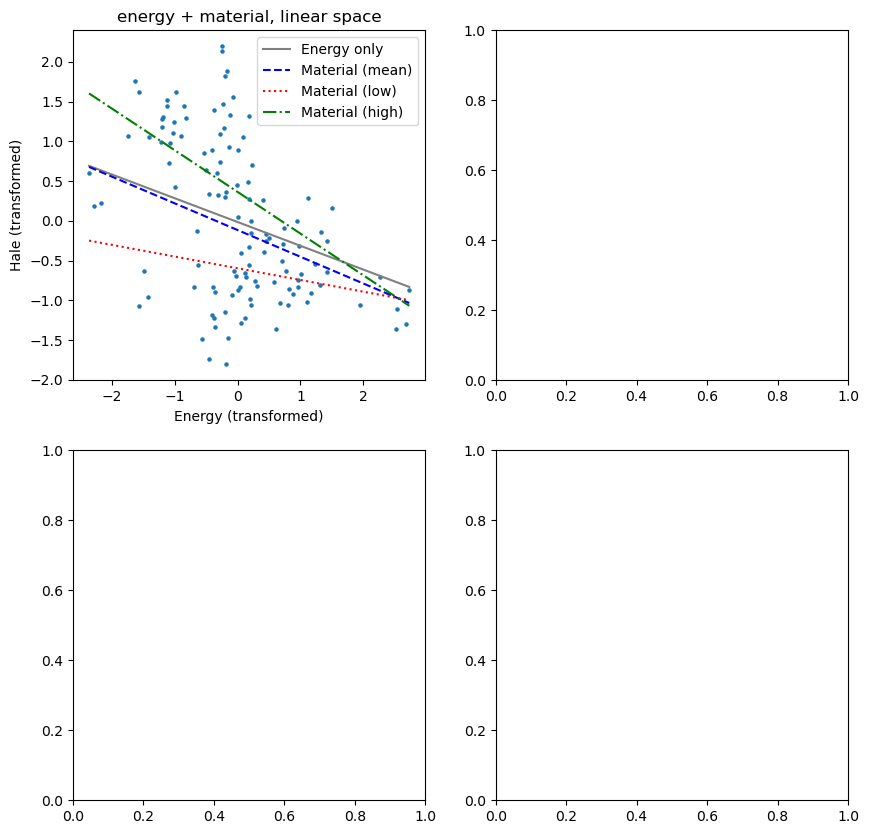

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(transformed_data["energy"], transformed_data["hale"], s=5)
axs[0, 0].set_title('energy + material, linear space')
axs[0, 0].set_xlabel('Energy (transformed)')
axs[0, 0].set_ylabel('Hale (transformed)')

# plot the predicted values
axs[0, 0].plot(bivariate_predictions["energy_transformed"], bivariate_predictions["predicted_hale"], color='gray', label='Energy only')
axs[0, 0].plot(single_predictions_mean["energy_transformed"], single_predictions_mean["predicted_hale"], color='blue', linestyle='--', label='Material (mean)')
axs[0, 0].plot(single_predictions_low["energy_transformed"], single_predictions_low["predicted_hale"], color='red', linestyle=':', label='Material (low)')
axs[0, 0].plot(single_predictions_high["energy_transformed"], single_predictions_high["predicted_hale"], color='green', linestyle='-.', label='Material (high)')
axs[0, 0].legend()

In [19]:
bivariate_predictions_back_transformed = predict_with_back_transform(
    bivariate_regressions[5]["model"],
    'hale',
    ['energy'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    back_transform_y=True
)
single_predictions_back_transformed_mean = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    back_transform_y=True
)
single_predictions_back_transformed_low = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    "LOW",
    back_transform_y=True
)
single_predictions_back_transformed_high = predict_with_back_transform(
    single_regressions[0]["model"],
    'hale',
    ['energy', 'material'],
    back_transformed_data_with_geo,
    transformed_data,
    scaler_df,
    [['energy', 'material']],
    "HIGH",
    back_transform_y=True
)

In [16]:
def log_tick_formatter(val, pos=None):
    return "{:.0f}".format(10**val)

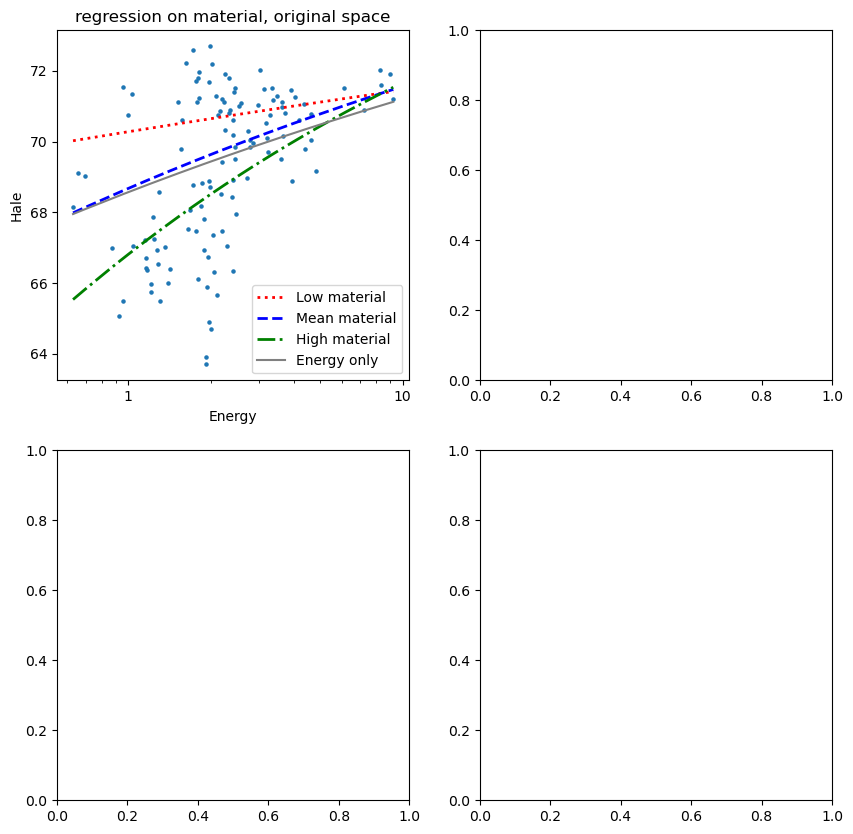

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(back_transformed_data["energy"], back_transformed_data["hale"], s=5)
axs[0, 0].set_title('energy + material, original space')
# log x axis
axs[0, 0].set_xscale('log')
axs[0, 0].xaxis.set_major_locator(LogLocator(base=10.0))
axs[0, 0].xaxis.set_major_formatter(FuncFormatter(lambda val, pos: "{:.0f}".format(val)))
axs[0, 0].set_xlabel('Energy')
axs[0, 0].set_ylabel('Hale')

# plot the predicted values
axs[0, 0].plot(single_predictions_back_transformed_low["energy"], single_predictions_back_transformed_low["predicted_hale"], color='red', linestyle=':', linewidth=2, label='Material (low)')
axs[0, 0].plot(single_predictions_back_transformed_mean["energy"], single_predictions_back_transformed_mean["predicted_hale"], color='blue', linestyle='--', linewidth=2, label='Material (mean)')
axs[0, 0].plot(single_predictions_back_transformed_high["energy"], single_predictions_back_transformed_high["predicted_hale"], color='green', linestyle='-.', linewidth=2, label='Material (high)')
axs[0, 0].plot(bivariate_predictions_back_transformed["energy"], bivariate_predictions_back_transformed["predicted_hale"], color='gray', label='Energy only')
axs[0, 0].legend()
# axs[0, 1].scatter(back_transformed_single_reg_data["energy"], back_transformed_single_reg_data["education"])
# axs[0, 1].set_title('education vs energy back-transformed')
# axs[1, 0].scatter(back_transformed_single_reg_data["energy"], back_transformed_single_reg_data["socialsupport"])
# axs[1, 0].set_title('socialsupport vs energy back-transformed')
# axs[1, 1].scatter(back_transformed_single_reg_data["energy"], back_transformed_single_reg_data["schoolenr"])
# axs[1, 1].set_title('schoolenr vs energy back-transformed')